# Check Platform Specification

In [0]:
#spesifikasi perangkat keras
!nvidia-smi -L
!lscpu |grep 'Model name'
!cat /proc/meminfo | grep 'MemAvailable'
!df -h / | awk '{print $4}'

GPU 0: Tesla K80 (UUID: GPU-5597209f-9321-5a92-2657-0a82c81439fa)
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
MemAvailable:   12490508 kB
Avail
310G


In [0]:
!python3 --version

Python 3.6.8


In [0]:
import platform
import torch
platform.system()
print("GPU :", torch.cuda.get_device_name(0))
print("OS : ", platform.dist())
print("CPU: ", platform.processor())

GPU : Tesla T4
OS :  ('Ubuntu', '18.04', 'bionic')
CPU:  x86_64


# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/program tesis/'
os.chdir(gdrive_path)
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/program tesis'

# Load Library yang digunakan

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=UserWarning, module='smart_open')

import re
import string
import codecs
import pandas as pd

import numpy as np # linear algebra
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils import shuffle
import argparse
import copy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import pickle

from prettytable import PrettyTable
import time
from datetime import timedelta

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing

In [0]:
class Preprocess:
    def __init__(self, list_text = None):
        self.texts = list_text
        self.preprocessed_text = []

    def preprocessing(self):
        for txt in self.texts:
            lowercase = self.huruf_kecil(txt)
            hapus_simbol = self.hapus_simbol(lowercase)
            normalisasi_kata = self.normalisasi_slang_word(hapus_simbol)
            self.preprocessed_text.append(normalisasi_kata)
        return self.preprocessed_text

    def huruf_kecil(self,txt):
        new_text = txt.split(' ')
        lowerkan = [x.lower() for x in new_text]
        new_text = " ".join(lowerkan)
        return new_text

    def hapus_simbol(self,word):
        word = word.split(' ')
        # Remove punctuation
        table = str.maketrans(string.punctuation," "*len(string.punctuation))
        word = [x.translate(table) for x in word]
        # Remove number
        word = [re.sub(r'\d+', '', x) for x in word]
        # Convert more than 2 letter repetitions to 2 letter
        # funnnnny --> funny
        word = [re.sub(r'(.)\1+', r'\1\1', x) for x in word]
        # Remove - & '
        word = [re.sub(r'(-|\')', '', x) for x in word]
        word = " ".join(word)
        return word

    def normalisasi_slang_word(self,txt):
        txt = txt.split(' ')
        dataSlang = [line for line in codecs.open('data/preprocessing_src/kata_baku_7500.txt').read().splitlines()]
        isiSlang = [data.split(';') for data in dataSlang]
        cekSlang = {value[0]:value[1] for value in isiSlang}
        for cekSlangKalimat in range(len(txt)):
            isiKalimatSlang = txt[cekSlangKalimat]
            # print(isiKalimatSlang)
            try:
                txt.insert(cekSlangKalimat, str(cekSlang[isiKalimatSlang]))
                txt.remove(txt[cekSlangKalimat+1])
            except:
                pass
        hasilSlang = " ".join(txt)
        return hasilSlang

In [0]:
#processing dataset aspek dan sentimen
path_input = "data/dataset/"
path_output = "data/dataset_preprocessed/"
data_path = ["data_aspek_labelled.csv","data_sentimen_labelled.csv"]

for i in data_path:
    data = pd.read_csv(path_input+i)
    teks = data['teks'].tolist()
    preprocess = Preprocess(teks)
    clean_text = preprocess.preprocessing()
    data = data.drop('teks',axis=1)
    data['teks'] = clean_text
    column = ['teks', 'akurasi', 'kualitas', 'pelayanan', 'pengemasan', 'harga', 'pengiriman']
    data[column].to_csv(path_output+i, index=False, encoding='utf-8')
    print('success')

# Pelatihan Word2Vec Model

In [0]:
preprocess raw data bukalapak for word2vec model
data = pd.read_csv('data/dataset/all_raw_data_bukalapak.csv')
teks = data['teks'].tolist()
preprocess = Preprocess(teks)
clean_text = preprocess.preprocessing()
data = data.drop('teks',axis=1)
data['teks'] = clean_text
column = ['teks', 'produk', 'toko']
data[column].to_csv('data/dataset_preprocessed/preprocessed_all_raw_data.csv', index=False, encoding='utf-8')

In [0]:
path = "data/dataset_preprocessed/preprocessed_all_raw_data.csv"

def read_teks(row, column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))

def save_word2vec_model(fileinputcsv, size):
    df = pd.read_csv(fileinputcsv)
    document = []
    for index, row in df.iterrows():
        document.append(read_teks(row,"teks"))

    model = gensim.models.Word2Vec(size=size, window=10, min_count=2, sg=1, workers=10)
    model.build_vocab(document)  # prepare the model vocabulary

    model.train(sentences=document, total_examples=len(document), epochs=model.epochs)
    model.wv.save_word2vec_format(f"data/model/word_embedding/bukalapak_word2vec_{size}.bin",binary=True)
    print(f"data/model/word_embedding/bukalapak_word2vec_{size}.bin", "Saved.")

# for i in [50, 100]:
#     save_word2vec_model(path, i)

# Utility

## Class dan Fungsi Load Dataset

In [0]:
class ReadData:
    def __init__(self, datafile_aspek, datafile_sentimen, vector_size, sentence_max_len):
        self.data = {}
        self.vector_size = vector_size
        self.sent_max_len = sentence_max_len
        self.x, self.y = [], []
        self.aspek_kategori = ['akurasi', 'kualitas', 'pelayanan', 'pengemasan', 'harga', 'pengiriman']
        self.df_aspek = pd.read_csv(datafile_aspek)
        self.df_sentimen = pd.read_csv(datafile_sentimen)
        self.all_teks = [x.split() for x in self.df_aspek['teks'].tolist()]
        for i in self.aspek_kategori:
            setattr(self, f'data_aspek_{i}', self.df_aspek['teks'].tolist())
            setattr(self, f'targets_aspek_{i}', self.df_aspek[i])
        for i in self.aspek_kategori:
            setattr(self, f'data_sentimen_{i}', self.df_sentimen['teks'])
            setattr(self, f'targets_sentimen_{i}', self.df_sentimen[i])
        self.datafile_aspek = datafile_aspek
        self.datafile_sentimen = datafile_sentimen
    
    def get_aspek(self, aspek):
        x = getattr(self, f'data_aspek_{aspek}')
        x = [x[i].split() for i in range(len(x))]
        y = getattr(self, f'targets_aspek_{aspek}')

        #group
        #-data true
        x_group, y_group = [],[]
        for i,j in zip(x,y):
            if j == 0:
                x_group.append(i)
                y_group.append(j)
        #-data false
        for i,j in zip(x,y):
            if j == 1:
                x_group.append(i)
                y_group.append(j)

        return x_group, y_group

    def get_aspek_w2v(self, aspek):
        x, y = self.get_aspek(aspek)
        data = self.dataframe_to_vector(x)
        data = np.asarray(data)
        labels = y
        labels = np.asarray(labels)
        return data, labels
    
    def get_sentimen(self,aspek):
        x = getattr(self, f'data_sentimen_{aspek}')
        x = [x[i].split() for i in range(len(x))]
        y = getattr(self, f'targets_sentimen_{aspek}')
        x_filter, y_filter = [],[]
        #filter hapus data yang tidak memiliki sentimen (-)
        for i, j in zip(x, y):
            if j != '-':
                x_filter.append(i)
                y_filter.append(j)
        
        #group
        x_group, y_group = [], []
        for i, j in zip(x_filter, y_filter):
            if j == 'positif':
                x_group.append(i)
                y_group.append(1)
        
        for i, j in zip(x_filter, y_filter):
            if j == 'negatif':
                x_group.append(i)
                y_group.append(0)
        
        return x_group, y_group

    def get_sentimen_w2v(self, aspek):
        x, y = self.get_sentimen(aspek)
        data = self.dataframe_to_vector(x)
        data = np.asarray(data)
        labels = y
        labels = np.asarray(labels)
        return data, labels
    
    def dataframe_to_vector(self, dataframe):
        path_wor2vec_model = f"data/model/word_embedding/bukalapak_word2vec_{self.vector_size}.bin"
        word2vec_vectors = []
        word_vectors = KeyedVectors.load_word2vec_format(path_wor2vec_model, binary=True)
        for sent in dataframe:
            sent2vec = self.sentence_to_vector(sent, word_vectors)
            word2vec_vectors.append(sent2vec)
        padd_word2vec_vectors = self.padding_dataframe(word2vec_vectors)
        return padd_word2vec_vectors
        
    def sentence_to_vector(self, sentence, word_vectors):
        wv_matrix = []
        for word in sentence:
            if word in word_vectors.vocab:
                wv_matrix.append(word_vectors.word_vec(word))
            else:
                wv_matrix.append(np.random.uniform(-0.01, 0.01, self.vector_size).astype("float32"))
        return wv_matrix
    
    def padding_dataframe(self, dataframe):
        padding_data = []
        for row in dataframe:
            pad_sent =self.padding_sentence(row, self.sent_max_len)
            padding_data.append(pad_sent)
        return padding_data
    
    def padding_sentence(self,vector_sentence, max_len):
        vector_sentence_size = len(vector_sentence)
        padding_size = max_len - vector_sentence_size
        padding = [np.zeros((self.vector_size),dtype="float32") for i in range(padding_size)]
        vector_sentence.extend(padding)
        return vector_sentence
    
    def distribusi_data(self):
            t = PrettyTable(['Label','Total Teks'])
            print('- data aspek')
            for i in self.aspek_kategori:
                data, labels = self.get_aspek(i)
                true_ = len([x for x in labels if x == 1])
                t.add_row([i,true_])
            print(t)

            t3 = PrettyTable(['kategori aspek','positif', 'negatif'])
            print('\n- data sentimen')
            for i in self.aspek_kategori:
                data, labels = self.get_sentimen(i)
                pos_ = len([x for x in labels if x == 1])
                neg_ = len([x for x in labels if x == 0])
                t3.add_row([i,pos_,neg_])
            print(t3)
    

## Fungsi hitung Akurasi, Presisi, Recall, dan f1

In [0]:
def hitung_score(y_test, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    print(fp, tp)
    acc = (tp+tn) / (tp + fp + tn + fn)
    prec = tp / (tp + fp)
    recc = tp / (tp + fn)
    f_1 = 2 * (prec * recc) / (prec + recc)
    return acc, prec, recc, f_1

In [0]:
y_pred = [1, 1, 0, 0, 0, 0, 0, 0]
y_test = [1, 1, 1, 1, 0, 0, 0, 0]

a, p, r, f = hitung_score(y_test, y_pred)
print('akurasi: ',a,'presisi: ', p, 'recall:', r, 'f-measure: ',f)

0 2
akurasi:  0.75 presisi:  1.0 recall: 0.5 f-measure:  0.6666666666666666


In [0]:
def hitung_score_multiclass(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred,labels=[-1,0,1])
    print(cm)
    total_true = np.sum(cm, axis=1)
    total_pred = np.sum(cm, axis=0)
    tp_a = cm[0][0]
    tp_b = cm[1][1]
    tp_c = cm[2][2]
    st_a = total_true[0]
    st_b = total_true[1]
    st_c = total_true[2]
    sp_a = total_pred[0]
    sp_b = total_pred[1]
    sp_c = total_pred[2]

    acc = (tp_a + tp_b + tp_c) / np.sum(total_true)
    prec = tp_c / sp_c
    recc = tp_c / st_c
    f1 = 2 * (prec * recc) / (prec + recc)
    return acc, prec, recc, f1

## Fungsi hitung waktu komputasi

In [0]:
def get_time_dif(start_time):
    """
    Return the time used since start_time.
    """
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

## Fungsi Simpan Hasil Eksperimen



In [0]:
class ExperimentNote:
    def __init__(self, outputfile):
        self.epoch = []
        self.train_acc = []
        self.train_loss = []
        self.test_acc = []
        self.test_loss = []
        self.time_dif = []
        self.outputfile = "data/Catatan Eksperimen/"+outputfile
    
    def append(self, epoch, train_acc, train_loss, test_acc, test_loss, time_dif):
        self.epoch.append(epoch)
        self.train_acc.append(train_acc)
        self.train_loss.append(train_loss)
        self.test_acc.append(test_acc)
        self.test_loss.append(test_loss)
        self.time_dif.append(time_dif)
    
    def save(self):
        df = pd.DataFrame()
        df['epoch'] = self.epoch
        df['train_acc'] = self.train_acc
        df['train_loss'] = self.train_loss
        df['test_acc'] = self.test_acc
        df['test_loss'] = self.test_loss
        df['time_dif'] = self.time_dif
        df.to_csv(self.outputfile)
    

# Arsitektur Model Metode

##Arsitektur CNN

- CNN_Sigmoid

In [0]:
class CNN_sigmoid(nn.Module):
    def __init__(self, **kwargs):
        super(CNN_sigmoid, self).__init__()
        self.MAX_SENT_LEN = kwargs['MAX_SENT_LEN']
        self.CLASS_SIZE = kwargs['CLASS_SIZE']
        self.FILTERS = kwargs['FILTERS']
        self.FILTERS_NUM = kwargs['FILTERS_NUM']
        self.DROPOUT_PROB = kwargs['DROPOUT_PROB']
        self.WORD_DIM = kwargs['WORD_DIM']
        self.CLASS_SIZE = 2
        self.IN_CHANNEL = 1

        self.conv1 = nn.Conv2d(self.IN_CHANNEL, self.FILTERS_NUM[0], self.FILTERS[0], stride=1)
        self.conv2 = nn.Conv2d(self.IN_CHANNEL, self.FILTERS_NUM[1], self.FILTERS[1], stride=1)
        self.conv3 = nn.Conv2d(self.IN_CHANNEL, self.FILTERS_NUM[2], self.FILTERS[2], stride=1)

        self.dropout = nn.Dropout(self.DROPOUT_PROB)
        self.fc = nn.Linear(sum(self.FILTERS_NUM), 1)
        
    def forward(self, inputs):
        x1 = F.relu(self.conv1(inputs))
        x2 = F.relu(self.conv2(inputs))
        x3 = F.relu(self.conv3(inputs))

        x1 = F.relu(x1)
        x2 = F.relu(x2)
        x3 = F.relu(x3)

        x1 = F.max_pool2d(x1, (152,1)).view(-1, self.FILTERS_NUM[0])
        x2 = F.max_pool2d(x2, (152,1)).view(-1, self.FILTERS_NUM[1])
        x3 = F.max_pool2d(x3, (152,1)).view(-1, self.FILTERS_NUM[2])

        x = torch.cat([x1,x2,x3],1)

        x = F.dropout(x, p=self.DROPOUT_PROB, training=True)
        # print(x.shape)
        x = self.fc(x)

        x = torch.sigmoid(x)
        return x

- CNN Softmax

In [0]:
class CNN_softmax(nn.Module):
    def __init__(self, **kwargs):
        super(CNN_softmax, self).__init__()
        self.MAX_SENT_LEN = kwargs['MAX_SENT_LEN']
        self.CLASS_SIZE = kwargs['CLASS_SIZE']
        self.FILTERS = kwargs['FILTERS']
        self.FILTERS_NUM = kwargs['FILTERS_NUM']
        self.DROPOUT_PROB = kwargs['DROPOUT_PROB']
        self.WORD_DIM = kwargs['WORD_DIM']
        self.CLASS_SIZE = 2
        self.IN_CHANNEL = 1

        self.conv1 = nn.Conv2d(self.IN_CHANNEL, self.FILTERS_NUM[0], self.FILTERS[0], stride=1)
        self.conv2 = nn.Conv2d(self.IN_CHANNEL, self.FILTERS_NUM[1], self.FILTERS[1], stride=1)
        self.conv3 = nn.Conv2d(self.IN_CHANNEL, self.FILTERS_NUM[2], self.FILTERS[2], stride=1)

        self.dropout = nn.Dropout(self.DROPOUT_PROB)
        self.fc = nn.Linear(sum(self.FILTERS_NUM), 2)
        
    def forward(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)

        x1 = F.relu(x1)
        x2 = F.relu(x2)
        x3 = F.relu(x3)

        x1 = F.max_pool2d(x1, (self.MAX_SENT_LEN - (self.FILTERS[0][0] - 1),1)).view(-1, self.FILTERS_NUM[0])
        x2 = F.max_pool2d(x2, (self.MAX_SENT_LEN - (self.FILTERS[1][0] - 1),1)).view(-1, self.FILTERS_NUM[1])
        x3 = F.max_pool2d(x3, (self.MAX_SENT_LEN - (self.FILTERS[2][0] - 1),1)).view(-1, self.FILTERS_NUM[2])

        x = torch.cat([x1,x2,x3],1)

        x = F.dropout(x, p=self.DROPOUT_PROB, training=True)
        # print(x.shape)
        x = self.fc(x)
        return x

# Klasifikasi

## Parameter

In [0]:
parameters = {
    "WORD_DIM": 300,
    "MAX_SENT_LEN": 154,
    "CHANNEL": 1,
    "FILTERS_NUM": [100,100,100],
    "FILTERS": [(3,300),(4,300),(5,300)],
    "EPOCH": 30,
    "BATCH_SIZE": 50,
    "CLASS_SIZE": 2,
    "DROPOUT_PROB": 0.5,
    "LEARNING_RATE": 0.01
}

## load data

In [0]:
datafile_aspek = "data/dataset_preprocessed/data_aspek_labelled.csv"
datafile_sentimen = "data/dataset_preprocessed/data_sentimen_labelled.csv"
dataset = ReadData(datafile_aspek, datafile_sentimen, parameters["WORD_DIM"], parameters["MAX_SENT_LEN"])

In [0]:
dataset.distribusi_data()

- data aspek
+------------+------------+
|   Label    | Total Teks |
+------------+------------+
|  akurasi   |    3220    |
|  kualitas  |    4345    |
| pelayanan  |    1359    |
| pengemasan |    1192    |
|   harga    |    1066    |
| pengiriman |    1599    |
+------------+------------+

- data sentimen
+----------------+---------+---------+
| kategori aspek | positif | negatif |
+----------------+---------+---------+
|    akurasi     |   2226  |   992   |
|    kualitas    |   3007  |   1337  |
|   pelayanan    |   880   |   479   |
|   pengemasan   |   806   |   386   |
|     harga      |   831   |   234   |
|   pengiriman   |   1142  |   458   |
+----------------+---------+---------+


## Load TF-IDF

In [0]:
def save_tfidf(tfidf, categori, mode, clf):
    with open(f'data/model/tf-idf/tfidf_{mode}_{categori}_{clf}.pkl', 'wb') as f:
        pickle.dump(tfidf, f)

def load_tfidf(categori, mode, clf):
    path = f'data/model/tf-idf/tfidf_{mode}_{categori}_{clf}.pkl'
    with open(path,'rb') as f:
        return pickle.load(f)

## Fungsi Training

In [0]:
def train_cnn(train_x,train_y,test_x,test_y):
    train_acc_history, train_loss_history, test_acc_history, test_loss_history = [],[],[],[]
    data_train = TensorDataset(torch.FloatTensor(train_x),torch.LongTensor(train_y))
    data_test = TensorDataset(torch.FloatTensor(test_x),torch.LongTensor(test_y))
    model = CNN_softmax(**parameters)
    model.cuda()
    criterion = nn.CrossEntropyLoss(size_average=False)
    # criterion = nn.BCELoss()
    # optimizer = optim.Adam(model.parameters(), lr=parameters["LEARNING_RATE"])

    optimizer = optim.Adadelta(model.parameters(), parameters["LEARNING_RATE"])
    start_time = time.time()
    
    pre_dev_acc = 0
    max_dev_acc = 0
    max_test_acc = 0
    best_model = None
    for e in range(parameters["EPOCH"]):
        model.train()
        train_loader = DataLoader(data_train, batch_size=parameters["BATCH_SIZE"])
        for x_batch, y_batch in train_loader:
            inputs, targets = Variable(x_batch), Variable(y_batch)

            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)  # forward computation
            loss = criterion(outputs, targets)

            # backward propagation and update parameters
            loss.backward()
            optimizer.step()
        train_acc, train_loss = evaluate(data_train, model, criterion)
        test_acc, test_loss = evaluate(data_test, model, criterion)
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)
        time_dif = get_time_dif(start_time)
        msg = "Epoch {0:3}, Train_loss: {1:>7.2%}, Train_acc {2:>6.2%}, " + "Test_loss: {3:>6.2%}, Test_acc {4:>6.2%}, Time: {5}"
        print(msg.format(e + 1, train_loss, train_acc, test_loss, test_acc, time_dif))
        if test_acc > max_test_acc:
            max_test_acc = test_acc
            best_model = copy.deepcopy(model)
    acc, prec, rec, f1 = test_model(best_model, data_test)
    return acc, prec, rec, f1

## Training Sequence Aspect and Sentiment

In [0]:
def train_cnn_2(train_x,train_y,test_x,test_y):
    train_acc_history, train_loss_history, test_acc_history, test_loss_history = [],[],[],[]
    data_train = TensorDataset(torch.FloatTensor(train_x),torch.LongTensor(train_y))
    data_test = TensorDataset(torch.FloatTensor(test_x),torch.LongTensor(test_y))
    model = CNN_softmax(**parameters)
    model.cuda()
    criterion = nn.CrossEntropyLoss(size_average=False)
    # criterion = nn.BCELoss()
    # optimizer = optim.Adam(model.parameters(), lr=parameters["LEARNING_RATE"])

    optimizer = optim.Adadelta(model.parameters(), parameters["LEARNING_RATE"])
    start_time = time.time()
    
    pre_dev_acc = 0
    max_dev_acc = 0
    max_test_acc = 0
    best_model = None
    for e in range(parameters["EPOCH"]):
        model.train()
        train_loader = DataLoader(data_train, batch_size=parameters["BATCH_SIZE"])
        for x_batch, y_batch in train_loader:
            inputs, targets = Variable(x_batch), Variable(y_batch)

            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)  # forward computation
            loss = criterion(outputs, targets)

            # backward propagation and update parameters
            loss.backward()
            optimizer.step()
        train_acc, train_loss = evaluate(data_train, model, criterion)
        test_acc, test_loss = evaluate(data_test, model, criterion)
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)
        time_dif = get_time_dif(start_time)
        msg = "Epoch {0:3}, Train_loss: {1:>7.2%}, Train_acc {2:>6.2%}, " + "Test_loss: {3:>6.2%}, Test_acc {4:>6.2%}, Time: {5}"
        print(msg.format(e + 1, train_loss, train_acc, test_loss, test_acc, time_dif))
        if test_acc > max_test_acc:
            max_test_acc = test_acc
            best_model = copy.deepcopy(model)
    return best_model

## Fungsi Evaluasi

In [0]:
def evaluate(data, model, loss):
    """
    Evaluation, return accuracy and loss
    """
    model.eval()  # set mode to evaluation to disable dropout
    data_loader = DataLoader(data, batch_size=50)

    data_len = len(data)
    total_loss = 0.0
    y_true, y_pred = [], []

    for data, label in data_loader:
        data, label = Variable(data, volatile=True), Variable(label, volatile=True)
        data, label = data.cuda(), label.cuda()

        output = model(data)
        losses = loss(output, label)

        total_loss += losses.item()
        pred = torch.max(output.data, dim=1)[1].cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(label.data)

    acc = (np.array(y_true) == np.array(y_pred)).sum()
    return acc / data_len, total_loss / data_len

In [0]:
def save_model(model,path):
    torch.save(model.state_dict(), path)
    print(f"A model is saved successfully as {path}!")

def load_model(model,path):
    model.load_state_dict(torch.load(path))

## Fungsi Testing

In [0]:
def test_model(model, data):
    model.eval()  # set mode to evaluation to disable dropout
    data_loader = DataLoader(data, batch_size=50)
    data_len = len(data)
    total_loss = 0.0
    y_true, y_pred = [], []

    for data, label in data_loader:
        data, label = Variable(data, volatile=True), Variable(label, volatile=True)
        data, label = data.cuda(), label.cuda()

        output = model(data)

        pred = torch.max(output.data, dim=1)[1].cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(label.tolist())
    acc, prec, recc, f1 = hitung_score(y_true, y_pred)
    return acc, prec, recc, f1

# Klasifikasi Kategori Aspek

## Pengujian Lebar Filter

In [0]:
filter_test = [[(2,300),(3,300),(4,300)],
               [(3,300),(4,300),(5,300)],
               [(4,300),(5,300),(6,300)]]
test_name = ["234","345","456"]
for i, filtr in enumerate(filter_test):
    print("Pengujian Filter:",filtr)
    list_score_cnn = []
    for category in dataset.aspek_kategori:
        print("="*10,category,"="*10)
        x,y = dataset.get_aspek_w2v(category)
        x = np.reshape(x, (len(x),1,154,300))
        parameters['EPOCH'] = 30
        parameters['FILTERS'] = filtr
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        trains, tests = [], []
        acc, prec, rec, f1 = 0, 0, 0, 0
        idx_k = 0
        start_time = time.time()
        for train, test in kfold.split(x):
            idx_k+=1
            print("K = ",idx_k)
            a, p, r, f = train_cnn(x[train], y[train], x[test], y[test])
            acc += a
            prec += p
            rec += r
            f1 += f
        time_dif = get_time_dif(start_time)
        print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "waktu" : time_dif.total_seconds()/60,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_score_cnn.append(score)
    df_cnn = pd.DataFrame.from_dict(list_score_cnn)
    df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
    df_sort.to_csv(f'data/Catatan Eksperimen 3/aspek_filter_{test_name[i]}_score.csv')
    print(f"- Model CNN filter {test_name[i]}\n",df_sort.round(2),"\n")

## Pengujian Jumlah Feature Map

In [0]:
filter_nums = [
               [400,400,400],
               [200,200,200],
               [100,100,100]
               ]
for filter_num in filter_nums:
    print("Pengujian Jumlah Feature Map:",filter_num)
    list_score_cnn = []
    for category in dataset.aspek_kategori:
        print("="*10,category,"="*10)
        x,y = dataset.get_aspek_w2v(category)
        x = np.reshape(x, (len(x),1,154,300))
        parameters['EPOCH'] = 30
        parameters['FILTERS'] = [(2,300),(3,300),(4,300)]
        parameters['FILTERS_NUM'] = filter_num
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        trains, tests = [], []
        acc, prec, rec, f1 = 0, 0, 0, 0
        idx_k = 0
        start_time = time.time()
        for train, test in kfold.split(x):
            idx_k+=1
            print("K = ",idx_k)
            a, p, r, f = train_cnn(x[train], y[train], x[test], y[test])
            acc += a
            prec += p
            rec += r
            f1 += f
        time_dif = get_time_dif(start_time)
        print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "waktu" : time_dif.total_seconds()/60,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_score_cnn.append(score)
    df_cnn = pd.DataFrame.from_dict(list_score_cnn)
    df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
    df_sort.to_csv(f'data/Catatan Eksperimen 3/aspek_filter_num_{filter_num[0]}_score.csv')
    print(f"- Model CNN Jumlah Feature Map {filter_num[0]}\n",df_sort.round(2),"\n")

Pengujian Jumlah Feature Map: [400, 400, 400]
========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  91.14%, Train_acc 42.83%, Test_loss: 90.70%, Test_acc 43.60%, Time: 0:00:04
Epoch   2, Train_loss:  87.23%, Train_acc 42.80%, Test_loss: 87.35%, Test_acc 43.60%, Time: 0:00:08
Epoch   3, Train_loss:  81.84%, Train_acc 42.87%, Test_loss: 81.30%, Test_acc 43.60%, Time: 0:00:13
Epoch   4, Train_loss:  76.52%, Train_acc 43.27%, Test_loss: 76.35%, Test_acc 43.80%, Time: 0:00:17
Epoch   5, Train_loss:  71.51%, Train_acc 44.53%, Test_loss: 71.08%, Test_acc 45.07%, Time: 0:00:21
Epoch   6, Train_loss:  66.60%, Train_acc 47.63%, Test_loss: 66.40%, Test_acc 47.87%, Time: 0:00:25
Epoch   7, Train_loss:  62.46%, Train_acc 52.32%, Test_loss: 61.98%, Test_acc 52.73%, Time: 0:00:29
Epoch   8, Train_loss:  58.58%, Train_acc 57.37%, Test_loss: 58.40%, Test_acc 57.67%, Time: 0:00:33
Epoch   9, Train_loss:  55.00%, Train_acc 63.35%, Test_loss: 54.70%, Test_acc 63.00%, Time: 0:00:38
Epoch  10, Train_loss:  51.54%, Train_acc 69.72%, Test_loss: 51.49%, Test_acc 68.73%, Time: 0:00:42


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


K =  2
Epoch   1, Train_loss:  91.99%, Train_acc 43.12%, Test_loss: 92.55%, Test_acc 42.47%, Time: 0:00:04
Epoch   2, Train_loss:  89.43%, Train_acc 43.12%, Test_loss: 90.19%, Test_acc 42.47%, Time: 0:00:09
Epoch   3, Train_loss:  83.42%, Train_acc 43.12%, Test_loss: 84.74%, Test_acc 42.47%, Time: 0:00:13
Epoch   4, Train_loss:  78.34%, Train_acc 43.30%, Test_loss: 80.00%, Test_acc 42.80%, Time: 0:00:18
Epoch   5, Train_loss:  73.15%, Train_acc 44.00%, Test_loss: 74.94%, Test_acc 43.53%, Time: 0:00:22
Epoch   6, Train_loss:  68.54%, Train_acc 46.13%, Test_loss: 70.52%, Test_acc 45.53%, Time: 0:00:27
Epoch   7, Train_loss:  64.06%, Train_acc 50.37%, Test_loss: 65.87%, Test_acc 48.47%, Time: 0:00:31
Epoch   8, Train_loss:  60.27%, Train_acc 54.65%, Test_loss: 62.38%, Test_acc 54.27%, Time: 0:00:35
Epoch   9, Train_loss:  56.85%, Train_acc 60.43%, Test_loss: 58.75%, Test_acc 59.13%, Time: 0:00:40
Epoch  10, Train_loss:  53.98%, Train_acc 64.68%, Test_loss: 56.19%, Test_acc 63.40%, Time: 0

## Pengujian Epoch

In [0]:
for epoch in [60,45]:
    list_score_cnn = []
    for category in dataset.aspek_kategori:
        print("="*10,category,"="*10)
        x,y = dataset.get_aspek_w2v(category)
        x = np.reshape(x, (len(x),1,154,300))
        parameters['EPOCH'] = epoch
        parameters['FILTERS'] = [(2,300),(3,300),(4,300)]
        parameters['FILTERS_NUM'] = [100,100,100]
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        trains, tests = [], []
        acc, prec, rec, f1 = 0, 0, 0, 0
        idx_k = 0
        start_time = time.time()
        for train, test in kfold.split(x):
            idx_k+=1
            print("K = ",idx_k)
            a, p, r, f = train_cnn(x[train], y[train], x[test], y[test])
            acc += a
            prec += p
            rec += r
            f1 += f
        time_dif = get_time_dif(start_time)
        print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "waktu" : time_dif.total_seconds()/60,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_score_cnn.append(score)
    df_cnn = pd.DataFrame.from_dict(list_score_cnn)
    df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
    df_sort.to_csv(f'data/Catatan Eksperimen 3/aspek_epoch_{epoch}_score.csv')
    print(f"- Model CNN epoch {epoch}\n",df_sort.round(2),"\n")

========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  72.64%, Train_acc 43.43%, Test_loss: 72.70%, Test_acc 43.93%, Time: 0:00:02
Epoch   2, Train_loss:  71.70%, Train_acc 43.20%, Test_loss: 71.71%, Test_acc 44.00%, Time: 0:00:04
Epoch   3, Train_loss:  68.95%, Train_acc 44.05%, Test_loss: 68.59%, Test_acc 44.80%, Time: 0:00:06
Epoch   4, Train_loss:  65.45%, Train_acc 46.75%, Test_loss: 65.57%, Test_acc 46.60%, Time: 0:00:08
Epoch   5, Train_loss:  61.46%, Train_acc 51.78%, Test_loss: 61.66%, Test_acc 52.00%, Time: 0:00:10
Epoch   6, Train_loss:  58.20%, Train_acc 58.77%, Test_loss: 58.22%, Test_acc 59.47%, Time: 0:00:12
Epoch   7, Train_loss:  54.78%, Train_acc 67.13%, Test_loss: 54.56%, Test_acc 66.73%, Time: 0:00:14
Epoch   8, Train_loss:  51.41%, Train_acc 74.77%, Test_loss: 51.56%, Test_acc 74.40%, Time: 0:00:15
Epoch   9, Train_loss:  48.58%, Train_acc 80.32%, Test_loss: 48.55%, Test_acc 79.47%, Time: 0:00:17
Epoch  10, Train_loss:  46.16%, Train_acc 83.67%, Test_loss: 45.93%, Test_acc 83.73%, Time: 0:00:19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Epoch   1, Train_loss:  74.18%, Train_acc 43.13%, Test_loss: 74.25%, Test_acc 42.33%, Time: 0:00:02
Epoch   2, Train_loss:  73.39%, Train_acc 43.10%, Test_loss: 73.90%, Test_acc 42.53%, Time: 0:00:04
Epoch   3, Train_loss:  70.46%, Train_acc 43.32%, Test_loss: 71.18%, Test_acc 42.67%, Time: 0:00:06
Epoch   4, Train_loss:  66.97%, Train_acc 44.35%, Test_loss: 68.23%, Test_acc 43.47%, Time: 0:00:08
Epoch   5, Train_loss:  63.05%, Train_acc 47.75%, Test_loss: 64.16%, Test_acc 46.60%, Time: 0:00:10
Epoch   6, Train_loss:  59.41%, Train_acc 54.82%, Test_loss: 60.74%, Test_acc 53.47%, Time: 0:00:12
Epoch   7, Train_loss:  55.57%, Train_acc 63.43%, Test_loss: 56.89%, Test_acc 61.93%, Time: 0:00:14
Epoch   8, Train_loss:  52.69%, Train_acc 69.92%, Test_loss: 54.28%, Test_acc 68.13%, Time: 0:00:16
Epoch   9, Train_loss:  49.74%, Train_acc 76.57%, Test_loss: 51.17%, Test_acc 75.07%, Time: 0:00:18
Epoch  10, Train_loss:  47.38%, Train_acc 80.13%, Test_loss: 49.17%, Test_acc 79.80%, Time: 0:00:19


## Pengujian Naive Bayes

In [0]:
list_akurasi = []
list_fitur = []
for i in range(100,1600,100):
    list_score_nb = []
    list_acc_temp = []
    for category in dataset.aspek_kategori:
    #     category = 'akurasi'
        data, labels = dataset.get_aspek(category);
        # data['classes'] = sorted(list(set(data['test_y'])))
        corpus = [" ".join(x) for x in data]
        vectorizer = TfidfVectorizer(max_features=i)
        save_tfidf(vectorizer.fit(corpus), category, 'aspek', 'mnb')
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        acc, prec, rec, f1 = 0,0,0,0
        k = 0
        for train_idx, test_idx in kfold.split(data):
            corpus = [" ".join(x) for x in [data[y] for y in train_idx]]
            tf_idf_matrix = TfidfVectorizer(max_features=i)
    #             tf_idf_matrix = load_tfidf(category,'sentimen', 'mnb')
            tf_idf_matrix.fit_transform(corpus)
            train_x = tf_idf_matrix.transform([" ".join(data[x]) for x in train_idx])
            train_y = [labels[x] for x in train_idx]
            test_x = tf_idf_matrix.transform([" ".join(data[x]) for x in test_idx])
            test_y = [labels[x] for x in test_idx]
            clf = MultinomialNB()
            clf.fit(train_x, train_y)
            pred_y = clf.predict(test_x)
            
            a, p, r, f = hitung_score(test_y,pred_y)
            k += 1
            # print("k=",k,"Aspek:",category,"/","akurasi:",a)
            acc += a
            prec += p
            rec += r
            f1 += f
        # print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_acc_temp.append(acc/5)
        list_score_nb.append(score)
    list_akurasi.append(sum(list_acc_temp)/6)
    list_fitur.append(i)
    print("feature: ",i)
    df_nb = pd.DataFrame.from_dict(list_score_nb)
    df_nb = df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']]
    # df_nb.to_csv(f'data/Catatan Eksperimen 2/aspek_best_params_mnb_score.csv')
    # print("- Model MNB\n",df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")
    print(sum(list_acc_temp)/6)
print(list_akurasi)

feature:  100
0.8857333333333334
feature:  200
0.8894888888888888
feature:  300
0.8922444444444445
feature:  400
0.8918
feature:  500
0.891488888888889
feature:  600
0.891
feature:  700
0.890488888888889
feature:  800
0.8906000000000001
feature:  900
0.8901333333333334
feature:  1000
0.889311111111111
feature:  1100
0.8877333333333334
feature:  1200
0.8871555555555556
feature:  1300
0.8857111111111111
feature:  1400
0.8839777777777779
feature:  1500
0.8831777777777777
[0.8857333333333334, 0.8894888888888888, 0.8922444444444445, 0.8918, 0.891488888888889, 0.891, 0.890488888888889, 0.8906000000000001, 0.8901333333333334, 0.889311111111111, 0.8877333333333334, 0.8871555555555556, 0.8857111111111111, 0.8839777777777779, 0.8831777777777777]


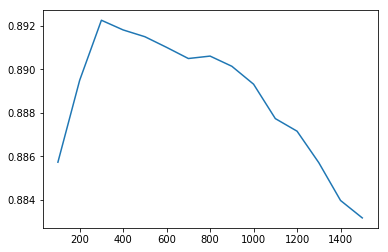

In [0]:
plt.plot(list_fitur,list_akurasi)
plt.show()

In [0]:
list_score_nb = []
for category in dataset.aspek_kategori:
#     category = 'akurasi'
    data, labels = dataset.get_aspek(category);
    # data['classes'] = sorted(list(set(data['test_y'])))
#     corpus = [" ".join(x) for x in data]
#     vectorizer = TfidfVectorizer(max_features=300)
#     save_tfidf(vectorizer.fit(corpus), category, 'aspek', 'mnb')
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    acc, prec, rec, f1 = 0,0,0,0
    k = 0
    for train_idx, test_idx in kfold.split(data):
        corpus = [" ".join(x) for x in [data[y] for y in train_idx]]
        tf_idf_matrix = TfidfVectorizer()
#             tf_idf_matrix = load_tfidf(category,'sentimen', 'mnb')
        tf_idf_matrix.fit_transform(corpus)
        train_x = tf_idf_matrix.transform([" ".join(data[x]) for x in train_idx])
        train_y = [labels[x] for x in train_idx]
        test_x = tf_idf_matrix.transform([" ".join(data[x]) for x in test_idx])
        test_y = [labels[x] for x in test_idx]
        clf = MultinomialNB()
        clf.fit(train_x, train_y)
        pred_y = clf.predict(test_x)
        
        a, p, r, f = hitung_score(test_y,pred_y)
        k += 1
        print("k=",k,"Aspek:",category,"/","akurasi:",a)
        acc += a
        prec += p
        rec += r
        f1 += f
    print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    score = {
            "label" : category,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    list_score_nb.append(score)
df_nb = pd.DataFrame.from_dict(list_score_nb)
df_nb = df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']]
df_nb.to_csv(f'data/Catatan Eksperimen 3/aspek_best_params_mnb_score.csv')
print("- Model MNB\n",df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")

k= 1 Aspek: akurasi / akurasi: 0.8646666666666667
k= 2 Aspek: akurasi / akurasi: 0.852
k= 3 Aspek: akurasi / akurasi: 0.8606666666666667
k= 4 Aspek: akurasi / akurasi: 0.8686666666666667
k= 5 Aspek: akurasi / akurasi: 0.878
K-Fold 5 rata-rata
 Akurasi:  0.8648000000000001 presisi:  0.9288752194128664 recall:  0.7419818673174159 F1: 0.8248526057702922
k= 1 Aspek: kualitas / akurasi: 0.7786666666666666
k= 2 Aspek: kualitas / akurasi: 0.7793333333333333
k= 3 Aspek: kualitas / akurasi: 0.7753333333333333
k= 4 Aspek: kualitas / akurasi: 0.7833333333333333
k= 5 Aspek: kualitas / akurasi: 0.7693333333333333
K-Fold 5 rata-rata
 Akurasi:  0.7771999999999999 presisi:  0.7616486610343626 recall:  0.8960842005885279 F1: 0.8233010022629864
k= 1 Aspek: pelayanan / akurasi: 0.8593333333333333
k= 2 Aspek: pelayanan / akurasi: 0.85
k= 3 Aspek: pelayanan / akurasi: 0.8573333333333333
k= 4 Aspek: pelayanan / akurasi: 0.8626666666666667
k= 5 Aspek: pelayanan / akurasi: 0.868
K-Fold 5 rata-rata
 Akurasi:  

## Pengujian SVM

In [0]:
data, labels = dataset.get_aspek(category);
# data['classes'] = sorted(list(set(data['test_y'])))
corpus = [" ".join(x) for x in data]
print(corpus)

['belum sebulan sudah kembung batre ya cape deh', 'sesuai dengan deskripsi bintang yang membuktikan', 'di kemas sangat baik dan aman', 'setelah saya coba sehari ternyata asli tidak kw super dan lain lain saran untuk yang melihat barang ini saya sarankan beli lah di sini b market kualitas real asli', 'pelapak direkomendasikan mantaapp', 'bagus dan memuaskan bagi pembeli', 'senang sekali belanja di b market keren', 'barang sesuai pesanan dan tidak neko dan mantap pokoknya', 'asli padahal cuma batre tapi pengemasan nya tebal banget top pengemasan nya respon pelapak cepat mudah awet batreny', 'asli mantap bos pertahankan', 'bagus sesuai pesanan sippsipp', 'barang bagus murah tapi kualitas sesuai iklan asli', 'harga miring', 'barang asli pokoknya mantap deh terima kasih penjual', 'produk baik', 'jos batrenya respon cepat tanggap terima kasih kakak', 'pengemasannya bagus tapi kok agak boros ya', 'cepat habis hampir sama aja sama batere saya yang sudah soak lama', 'semoga awet dipakai barangn

In [0]:
list_akurasi = []
list_fitur = []
for i in range(100,1600,100):
    list_score_svm = []
    list_acc_temp = []
    for category in dataset.aspek_kategori:
    #     category = 'akurasi'
        data, labels = dataset.get_aspek(category);
        # data['classes'] = sorted(list(set(data['test_y'])))
        corpus = [" ".join(x) for x in data]
        vectorizer = TfidfVectorizer(max_features=i)
        save_tfidf(vectorizer.fit(corpus), category, 'aspek', 'svm')
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        acc, prec, rec, f1 = 0,0,0,0
        k = 0
        for train_idx, test_idx in kfold.split(data):
            tf_idf_matrix = load_tfidf(category,'aspek', 'svm')
            train_x = tf_idf_matrix.transform([" ".join(data[x]) for x in train_idx])
            train_y = [labels[x] for x in train_idx]
            test_x = tf_idf_matrix.transform([" ".join(data[x]) for x in test_idx])
            test_y = [labels[x] for x in test_idx]
            clf = LinearSVC()
            clf.fit(train_x, train_y)
            pred_y = clf.predict(test_x)
            
            a, p, r, f = hitung_score(test_y,pred_y)
            k += 1
            # print("k=",k,"Aspek:",category,"/","akurasi:",a)
            acc += a
            prec += p
            rec += r
            f1 += f
        # print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_acc_temp.append(acc/5)
        list_score_svm.append(score)
#     list_akurasi.append(sum(list_acc_temp)/6)
#     list_fitur.append(i)
    print("feature: ",i)
    df_svm = pd.DataFrame.from_dict(list_score_svm)
    df_svm = df_svm[['label', 'akurasi', 'presisi', 'recall', 'f1']]
    # df_nb.to_csv(f'data/Catatan Eksperimen 2/aspek_best_params_svm_score.csv')
    # print("- Model MNB\n",df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")
    print(sum(list_acc_temp)/6)
print(list_akurasi)

feature:  100
0.9224222222222221
feature:  200
0.9290222222222222
feature:  300
0.9322888888888888
feature:  400
0.9338666666666667
feature:  500
0.9338000000000001
feature:  600
0.9335111111111111
feature:  700
0.9342666666666668
feature:  800
0.9345555555555555
feature:  900
0.9341333333333334
feature:  1000
0.9348666666666666
feature:  1100
0.9349333333333333
feature:  1200
0.9343333333333333
feature:  1300
0.9344444444444444
feature:  1400
0.9345777777777777
feature:  1500
0.9340222222222222
[]


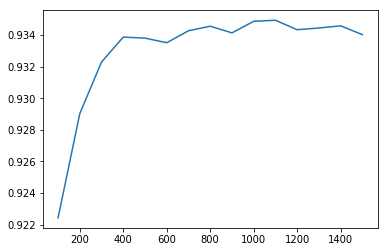

In [0]:
plt.plot(list_fitur,list_akurasi)
plt.show()

In [0]:
list_score_svm = []
list_acc_temp = []
for category in dataset.aspek_kategori:
#     category = 'akurasi'
    data, labels = dataset.get_aspek(category);
    # data['classes'] = sorted(list(set(data['test_y'])))
#     corpus = [" ".join(x) for x in data]
#     vectorizer = TfidfVectorizer(max_features=1100)
#     save_tfidf(vectorizer.fit(corpus), category, 'aspek', 'svm')
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    acc, prec, rec, f1 = 0,0,0,0
    k = 0
    for train_idx, test_idx in kfold.split(data):
#         tf_idf_matrix = load_tfidf(category,'aspek', 'svm')
        corpus = [" ".join(x) for x in [data[y] for y in train_idx]]
        tf_idf_matrix = TfidfVectorizer(max_features=100)
#             tf_idf_matrix = load_tfidf(category,'sentimen', 'mnb')
        tf_idf_matrix.fit_transform(corpus)
        train_x = tf_idf_matrix.transform([" ".join(data[x]) for x in train_idx])
        train_y = [labels[x] for x in train_idx]
        test_x = tf_idf_matrix.transform([" ".join(data[x]) for x in test_idx])
        test_y = [labels[x] for x in test_idx]
        clf = SVC(gamma='auto')
        clf.fit(train_x, train_y)
        pred_y = clf.predict(test_x)
        
        a, p, r, f = hitung_score(test_y,pred_y)
        k += 1
        print("k=",k,"Aspek:",category,"/","akurasi:",a)
        acc += a
        prec += p
        rec += r
        f1 += f
    print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    score = {
            "label" : category,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    list_score_svm.append(score)
df_svm = pd.DataFrame.from_dict(list_score_svm)
df_svm = df_svm[['label', 'akurasi', 'presisi', 'recall', 'f1']]
df_svm.to_csv(f'data/Catatan Eksperimen 2/aspek_best_params_svm_score.csv')
print("- Model SVM\n",df_svm[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")

k= 1 Aspek: akurasi / akurasi: 0.8593333333333333
k= 2 Aspek: akurasi / akurasi: 0.864
k= 3 Aspek: akurasi / akurasi: 0.864
k= 4 Aspek: akurasi / akurasi: 0.872
k= 5 Aspek: akurasi / akurasi: 0.8773333333333333
K-Fold 5 rata-rata
 Akurasi:  0.8673333333333332 presisi:  0.9360483984137689 recall:  0.7419134193893999 F1: 0.8276134571020275
k= 1 Aspek: kualitas / akurasi: 0.7713333333333333
k= 2 Aspek: kualitas / akurasi: 0.7686666666666667
k= 3 Aspek: kualitas / akurasi: 0.782
k= 4 Aspek: kualitas / akurasi: 0.7753333333333333
k= 5 Aspek: kualitas / akurasi: 0.76
K-Fold 5 rata-rata
 Akurasi:  0.7714666666666666 presisi:  0.754111831824087 recall:  0.8993546925815575 F1: 0.8201231283039409
k= 1 Aspek: pelayanan / akurasi: 0.9093333333333333
k= 2 Aspek: pelayanan / akurasi: 0.9013333333333333
k= 3 Aspek: pelayanan / akurasi: 0.8993333333333333
k= 4 Aspek: pelayanan / akurasi: 0.9066666666666666
k= 5 Aspek: pelayanan / akurasi: 0.91
K-Fold 5 rata-rata
 Akurasi:  0.9053333333333333 presisi: 

## Pengujian Prediksi aspek

In [0]:
x,y = dataset.get_aspek("harga")
# print(" ".join(x[1]))
# print(x[[1,2]])
kfold = KFold(n_splits=5, shuffle=True, random_state=44)
for train, test in kfold.split(x):
    for i in test:
        print(" ".join(x[i]))
        break
#     print(x[test])

barang bagus cepat sampai lagi
asli padahal cuma batre tapi pengemasan nya tebal banget top pengemasan nya respon pelapak cepat mudah awet batreny
di kemas sangat baik dan aman
setelah saya coba sehari ternyata asli tidak kw super dan lain lain saran untuk yang melihat barang ini saya sarankan beli lah di sini b market kualitas real asli
belum sebulan sudah kembung batre ya cape deh


In [0]:
list_score_cnn = []
for category in dataset.aspek_kategori:
    print("="*10,category,"="*10)
    teks_x, _ = dataset.get_aspek(category)
    x,y = dataset.get_aspek_w2v(category)
    x = np.reshape(x, (len(x),1,154,300))
    parameters['EPOCH'] = 60
    parameters['FILTERS'] = [(2,300),(3,300),(4,300)]
    parameters['FILTERS_NUM'] = [100,100,100]
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    trains, tests = [], []
    acc, prec, rec, f1 = 0, 0, 0, 0
    idx_k = 0
    start_time = time.time()
    for train, test in kfold.split(x):
        idx_k+=1
        print("K = ",idx_k)
        
        
        model_aspek = train_cnn_2(x[train], y[train], x[test], y[test])
        output_asp = model_aspek(torch.cuda.FloatTensor(x[test]))
        save_model(model_aspek,f"data/Catatan Eksperimen 4/model/model_aspek_{category}_k_{idx_k}")
        pred_asp = torch.max(output_asp.data, dim=1)[1].cpu().numpy().tolist()
        
        pred_csv = []
        for i,j in zip(test,pred_asp):
            pred_csv_item = {
                "teks": " ".join(teks_x[i]),
                "prediksi": j,
                "target": y[i]
            }
            pred_csv.append(pred_csv_item)
        df_pred = pd.DataFrame.from_dict(pred_csv)
        df_pred_sort = df_pred[['teks', 'prediksi', 'target']]
        df_pred_sort.to_csv(f'data/Catatan Eksperimen 4/data_hasil/prediksi_aspek_{category}_k_{idx_k}.csv')
        
        a, p, r, f = hitung_score(y[test],pred_asp)
        acc += a
        prec += p
        rec += r
        f1 += f

    time_dif = get_time_dif(start_time)
    print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    score = {
            "label" : category,
            "waktu" : time_dif.total_seconds()/60,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    list_score_cnn.append(score)
df_cnn = pd.DataFrame.from_dict(list_score_cnn)
df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
df_sort.to_csv(f'data/Catatan Eksperimen 4/aspek_prediksi_score.csv')
print(f"- Model CNN epoch \n",df_sort.round(2),"\n")

========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  73.30%, Train_acc 42.87%, Test_loss: 73.05%, Test_acc 43.73%, Time: 0:00:02
Epoch   2, Train_loss:  71.84%, Train_acc 42.97%, Test_loss: 71.72%, Test_acc 43.93%, Time: 0:00:04
Epoch   3, Train_loss:  68.92%, Train_acc 43.52%, Test_loss: 68.69%, Test_acc 44.13%, Time: 0:00:06
Epoch   4, Train_loss:  65.63%, Train_acc 46.05%, Test_loss: 65.99%, Test_acc 46.80%, Time: 0:00:08
Epoch   5, Train_loss:  61.62%, Train_acc 51.63%, Test_loss: 61.61%, Test_acc 52.73%, Time: 0:00:10
Epoch   6, Train_loss:  58.18%, Train_acc 58.68%, Test_loss: 58.17%, Test_acc 58.27%, Time: 0:00:12
Epoch   7, Train_loss:  54.97%, Train_acc 66.67%, Test_loss: 54.78%, Test_acc 66.93%, Time: 0:00:14
Epoch   8, Train_loss:  51.96%, Train_acc 73.83%, Test_loss: 51.87%, Test_acc 73.27%, Time: 0:00:16
Epoch   9, Train_loss:  49.27%, Train_acc 78.55%, Test_loss: 49.29%, Test_acc 78.13%, Time: 0:00:18
Epoch  10, Train_loss:  46.58%, Train_acc 82.57%, Test_loss: 46.99%, Test_acc 81.73%, Time: 0:00:20


# Klasifikasi Sentimen

In [0]:
#parameter
parameters = {
    "WORD_DIM": 300,
    "MAX_SENT_LEN": 154,
    "CHANNEL": 1,
    "FILTERS_NUM": [100,100,100],
    "FILTERS": [(3,300),(4,300),(5,300)],
    "EPOCH": 30,
    "BATCH_SIZE": 50,
    "CLASS_SIZE": 2,
    "DROPOUT_PROB": 0.5,
    "LEARNING_RATE": 0.01
}

## Pengujian Lebar Filter

In [0]:
filter_test = [[(2,300),(3,300),(4,300)],
               [(3,300),(4,300),(5,300)],
               [(4,300),(5,300),(6,300)]]
test_name = ["234","345","456"]
for i, filtr in enumerate(filter_test):
    print("Pengujian Filter:",filtr)
    list_score_cnn = []
    for category in dataset.aspek_kategori:
        print("="*10,category,"="*10)
        x,y = dataset.get_sentimen_w2v(category)
        x = np.reshape(x, (len(x),1,154,300))
        parameters['FILTERS'] = filtr
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        trains, tests = [], []
        acc, prec, rec, f1 = 0, 0, 0, 0
        idx_k = 0
        start_time = time.time()
        for train, test in kfold.split(x):
            idx_k+=1
            print("K = ",idx_k)
            a, p, r, f = train_cnn(x[train], y[train], x[test], y[test])
            acc += a
            prec += p
            rec += r
            f1 += f
        time_dif = get_time_dif(start_time)
        print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "waktu" : time_dif.total_seconds()/60,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_score_cnn.append(score)
    df_cnn = pd.DataFrame.from_dict(list_score_cnn)
    df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
    df_sort.to_csv(f'data/Catatan Eksperimen 3/sentimen_filter_{test_name[i]}_score.csv')
    print(f"- Model CNN filter {test_name[i]}\n",df_sort.round(2),"\n")

Pengujian Filter: [(2, 300), (3, 300), (4, 300)]
========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  61.22%, Train_acc 73.27%, Test_loss: 61.88%, Test_acc 71.89%, Time: 0:00:01
Epoch   2, Train_loss:  56.23%, Train_acc 73.12%, Test_loss: 57.14%, Test_acc 71.27%, Time: 0:00:02
Epoch   3, Train_loss:  52.63%, Train_acc 74.55%, Test_loss: 54.46%, Test_acc 73.29%, Time: 0:00:03
Epoch   4, Train_loss:  49.75%, Train_acc 77.74%, Test_loss: 51.23%, Test_acc 75.31%, Time: 0:00:03
Epoch   5, Train_loss:  47.15%, Train_acc 81.27%, Test_loss: 48.95%, Test_acc 77.02%, Time: 0:00:04
Epoch   6, Train_loss:  44.71%, Train_acc 83.84%, Test_loss: 47.13%, Test_acc 79.81%, Time: 0:00:05
Epoch   7, Train_loss:  42.78%, Train_acc 86.17%, Test_loss: 45.27%, Test_acc 82.76%, Time: 0:00:06
Epoch   8, Train_loss:  40.87%, Train_acc 88.46%, Test_loss: 42.91%, Test_acc 84.16%, Time: 0:00:07
Epoch   9, Train_loss:  39.02%, Train_acc 89.70%, Test_loss: 41.32%, Test_acc 86.02%, Time: 0:00:08
Epoch  10, Train_loss:  37.36%, Train_acc 90.75%, Test_loss: 39.69%, Test_acc 85.87%, Time: 0:00:08


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Epoch   1, Train_loss:  61.56%, Train_acc 76.26%, Test_loss: 61.62%, Test_acc 76.24%, Time: 0:00:01
Epoch   2, Train_loss:  56.70%, Train_acc 75.52%, Test_loss: 56.34%, Test_acc 76.24%, Time: 0:00:02
Epoch   3, Train_loss:  52.88%, Train_acc 78.28%, Test_loss: 52.14%, Test_acc 80.59%, Time: 0:00:02
Epoch   4, Train_loss:  49.94%, Train_acc 80.57%, Test_loss: 49.83%, Test_acc 81.68%, Time: 0:00:03
Epoch   5, Train_loss:  47.17%, Train_acc 83.88%, Test_loss: 46.95%, Test_acc 85.09%, Time: 0:00:04
Epoch   6, Train_loss:  44.77%, Train_acc 86.64%, Test_loss: 44.56%, Test_acc 87.27%, Time: 0:00:05
Epoch   7, Train_loss:  42.12%, Train_acc 88.66%, Test_loss: 42.09%, Test_acc 89.29%, Time: 0:00:06
Epoch   8, Train_loss:  40.62%, Train_acc 89.98%, Test_loss: 40.03%, Test_acc 91.93%, Time: 0:00:07
Epoch   9, Train_loss:  38.57%, Train_acc 90.37%, Test_loss: 38.12%, Test_acc 93.01%, Time: 0:00:07
Epoch  10, Train_loss:  37.14%, Train_acc 90.91%, Test_loss: 37.12%, Test_acc 91.30%, Time: 0:00:08


## Pengujian Jumlah Feature Map

In [0]:
filter_nums = [
               [400,400,400],
               [200,200,200]
               ]
for filter_num in filter_nums:
    print("Pengujian Jumlah Feature Map:",filter_num)
    list_score_cnn = []
    for category in dataset.aspek_kategori:
        print("="*10,category,"="*10)
        x,y = dataset.get_sentimen_w2v(category)
        x = np.reshape(x, (len(x),1,154,300))
        parameters['EPOCH'] = 30
        parameters['FILTERS'] = [(3,300),(4,300),(5,300)]
        parameters['FILTERS_NUM'] = filter_num
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        trains, tests = [], []
        acc, prec, rec, f1 = 0, 0, 0, 0
        idx_k = 0
        start_time = time.time()
        for train, test in kfold.split(x):
            idx_k+=1
            print("K = ",idx_k)
            a, p, r, f = train_cnn(x[train], y[train], x[test], y[test])
            acc += a
            prec += p
            rec += r
            f1 += f
        time_dif = get_time_dif(start_time)
        print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "waktu" : time_dif.total_seconds()/60,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_score_cnn.append(score)
    df_cnn = pd.DataFrame.from_dict(list_score_cnn)
    df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
    df_sort.to_csv(f'data/Catatan Eksperimen 3/sentimen_filter_num_{filter_num[0]}_score.csv')
    print(f"- Model CNN Jumlah Feature Map {filter_num[0]}\n",df_sort.round(2),"\n")

Pengujian Jumlah Feature Map: [400, 400, 400]
========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  59.29%, Train_acc 77.54%, Test_loss: 60.51%, Test_acc 73.60%, Time: 0:00:02
Epoch   2, Train_loss:  52.82%, Train_acc 86.29%, Test_loss: 54.22%, Test_acc 83.54%, Time: 0:00:04
Epoch   3, Train_loss:  48.02%, Train_acc 89.39%, Test_loss: 49.86%, Test_acc 87.58%, Time: 0:00:06
Epoch   4, Train_loss:  43.91%, Train_acc 90.25%, Test_loss: 46.19%, Test_acc 88.98%, Time: 0:00:08
Epoch   5, Train_loss:  40.32%, Train_acc 91.06%, Test_loss: 42.97%, Test_acc 89.44%, Time: 0:00:10
Epoch   6, Train_loss:  37.44%, Train_acc 90.56%, Test_loss: 39.71%, Test_acc 90.06%, Time: 0:00:12
Epoch   7, Train_loss:  34.92%, Train_acc 91.14%, Test_loss: 37.21%, Test_acc 91.30%, Time: 0:00:15
Epoch   8, Train_loss:  32.84%, Train_acc 91.03%, Test_loss: 35.18%, Test_acc 90.37%, Time: 0:00:17
Epoch   9, Train_loss:  31.05%, Train_acc 90.99%, Test_loss: 33.37%, Test_acc 90.84%, Time: 0:00:19
Epoch  10, Train_loss:  29.41%, Train_acc 90.91%, Test_loss: 31.62%, Test_acc 91.77%, Time: 0:00:21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Epoch   1, Train_loss:  61.09%, Train_acc 84.73%, Test_loss: 60.79%, Test_acc 85.71%, Time: 0:00:02
Epoch   2, Train_loss:  53.88%, Train_acc 87.92%, Test_loss: 53.46%, Test_acc 88.82%, Time: 0:00:04
Epoch   3, Train_loss:  48.65%, Train_acc 88.73%, Test_loss: 48.26%, Test_acc 90.06%, Time: 0:00:06
Epoch   4, Train_loss:  44.39%, Train_acc 88.73%, Test_loss: 43.93%, Test_acc 89.75%, Time: 0:00:09
Epoch   5, Train_loss:  41.05%, Train_acc 88.77%, Test_loss: 40.47%, Test_acc 88.82%, Time: 0:00:11
Epoch   6, Train_loss:  37.90%, Train_acc 89.70%, Test_loss: 37.86%, Test_acc 88.98%, Time: 0:00:13
Epoch   7, Train_loss:  35.60%, Train_acc 89.28%, Test_loss: 35.29%, Test_acc 89.13%, Time: 0:00:15
Epoch   8, Train_loss:  33.25%, Train_acc 89.78%, Test_loss: 32.76%, Test_acc 89.29%, Time: 0:00:17
Epoch   9, Train_loss:  31.55%, Train_acc 89.82%, Test_loss: 31.36%, Test_acc 89.44%, Time: 0:00:19
Epoch  10, Train_loss:  29.75%, Train_acc 90.33%, Test_loss: 29.29%, Test_acc 90.68%, Time: 0:00:21


## Pengujian Epoch

In [0]:
for epoch in [45,60]:
    list_score_cnn = []
    for category in dataset.aspek_kategori:
        print("="*10,category,"="*10)
        x,y = dataset.get_sentimen_w2v(category)
        x = np.reshape(x, (len(x),1,154,300))
        parameters['EPOCH'] = epoch
        parameters['FILTERS'] = [(3,300),(4,300),(5,300)]
        parameters['FILTERS_NUM'] = [400,400,400]
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        trains, tests = [], []
        acc, prec, rec, f1 = 0, 0, 0, 0
        idx_k = 0
        start_time = time.time()
        for train, test in kfold.split(x):
            idx_k+=1
            print("K = ",idx_k)
            a, p, r, f = train_cnn(x[train], y[train], x[test], y[test])
            acc += a
            prec += p
            rec += r
            f1 += f
        time_dif = get_time_dif(start_time)
        print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "waktu" : time_dif.total_seconds()/60,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_score_cnn.append(score)
    df_cnn = pd.DataFrame.from_dict(list_score_cnn)
    df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
    df_sort.to_csv(f'data/Catatan Eksperimen 3/sentimen_epoch_{epoch}_score.csv')
    print(f"- Model CNN epoch {epoch}\n",df_sort.round(2),"\n")

========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  59.58%, Train_acc 78.44%, Test_loss: 59.80%, Test_acc 77.80%, Time: 0:00:02
Epoch   2, Train_loss:  53.00%, Train_acc 86.29%, Test_loss: 54.46%, Test_acc 84.32%, Time: 0:00:04
Epoch   3, Train_loss:  48.12%, Train_acc 89.74%, Test_loss: 49.95%, Test_acc 86.80%, Time: 0:00:06
Epoch   4, Train_loss:  43.63%, Train_acc 90.83%, Test_loss: 45.60%, Test_acc 88.35%, Time: 0:00:09
Epoch   5, Train_loss:  40.30%, Train_acc 90.68%, Test_loss: 42.29%, Test_acc 90.53%, Time: 0:00:11
Epoch   6, Train_loss:  37.63%, Train_acc 90.48%, Test_loss: 39.46%, Test_acc 90.37%, Time: 0:00:13
Epoch   7, Train_loss:  35.01%, Train_acc 90.68%, Test_loss: 37.34%, Test_acc 90.53%, Time: 0:00:15
Epoch   8, Train_loss:  32.89%, Train_acc 90.44%, Test_loss: 34.98%, Test_acc 90.99%, Time: 0:00:17
Epoch   9, Train_loss:  31.06%, Train_acc 90.83%, Test_loss: 33.42%, Test_acc 90.53%, Time: 0:00:19
Epoch  10, Train_loss:  29.49%, Train_acc 90.99%, Test_loss: 32.17%, Test_acc 91.46%, Time: 0:00:21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Epoch   1, Train_loss:  60.72%, Train_acc 84.19%, Test_loss: 60.63%, Test_acc 85.56%, Time: 0:00:02
Epoch   2, Train_loss:  53.81%, Train_acc 87.65%, Test_loss: 53.30%, Test_acc 88.66%, Time: 0:00:04
Epoch   3, Train_loss:  48.48%, Train_acc 89.16%, Test_loss: 47.85%, Test_acc 89.44%, Time: 0:00:06
Epoch   4, Train_loss:  44.40%, Train_acc 89.01%, Test_loss: 44.15%, Test_acc 89.29%, Time: 0:00:09
Epoch   5, Train_loss:  41.09%, Train_acc 89.04%, Test_loss: 40.46%, Test_acc 89.13%, Time: 0:00:11
Epoch   6, Train_loss:  37.97%, Train_acc 89.16%, Test_loss: 37.67%, Test_acc 88.66%, Time: 0:00:13
Epoch   7, Train_loss:  35.61%, Train_acc 89.55%, Test_loss: 35.20%, Test_acc 89.91%, Time: 0:00:15
Epoch   8, Train_loss:  33.64%, Train_acc 89.63%, Test_loss: 33.32%, Test_acc 89.91%, Time: 0:00:17
Epoch   9, Train_loss:  31.71%, Train_acc 89.94%, Test_loss: 30.91%, Test_acc 90.68%, Time: 0:00:19
Epoch  10, Train_loss:  29.87%, Train_acc 90.21%, Test_loss: 29.13%, Test_acc 90.06%, Time: 0:00:21


## Pengujian Naive Bayes

In [0]:
list_akurasi = []
list_fitur = []
for i in range(100,1600,100):
    list_score_nb = []
    list_acc_temp = []
    for category in dataset.aspek_kategori:
    #     category = 'akurasi'
        data, labels = dataset.get_sentimen(category);
        # data['classes'] = sorted(list(set(data['test_y'])))
        corpus = [" ".join(x) for x in data]
        vectorizer = TfidfVectorizer(max_features=i)
        save_tfidf(vectorizer.fit(corpus), category, 'sentimen', 'mnb')
        kfold = KFold(n_splits=5, shuffle=True, random_state=44)
        acc, prec, rec, f1 = 0,0,0,0
        k = 0
        for train_idx, test_idx in kfold.split(data):
            corpus = [" ".join(x) for x in [data[y] for y in train_idx]]
            tf_idf_matrix = TfidfVectorizer(max_features=i)
#             tf_idf_matrix = load_tfidf(category,'sentimen', 'mnb')
            tf_idf_matrix.fit_transform(corpus)
            train_x = tf_idf_matrix.transform([" ".join(data[x]) for x in train_idx])
            train_y = [labels[x] for x in train_idx]
            test_x = tf_idf_matrix.transform([" ".join(data[x]) for x in test_idx])
            test_y = [labels[x] for x in test_idx]
            clf = MultinomialNB()
            clf.fit(train_x, train_y)
            pred_y = clf.predict(test_x)
            
            a, p, r, f = hitung_score(test_y,pred_y)
            k += 1
            # print("k=",k,"Aspek:",category,"/","akurasi:",a)
            acc += a
            prec += p
            rec += r
            f1 += f
        # print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
        score = {
                "label" : category,
                "akurasi" : acc/5,
                "presisi" : prec/5,
                "recall" : rec/5,
                "f1" : f1/5
            }
        list_acc_temp.append(acc/5)
        list_score_nb.append(score)
    list_akurasi.append(sum(list_acc_temp)/6)
    list_fitur.append(i)
    print("feature: ",i)
    df_nb = pd.DataFrame.from_dict(list_score_nb)
    df_nb = df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']]
    # df_nb.to_csv(f'data/Catatan Eksperimen 2/sentimen_best_params_mnb_score.csv')
    # print("- Model MNB\n",df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")
    print(sum(list_acc_temp)/6)
print(list_akurasi)

feature:  100
0.891015279572803
feature:  200
0.8994412089570503
feature:  300
0.8994701911049039
feature:  400
0.8965964416012131
feature:  500
0.8955030496657148
feature:  600
0.8915274903233891
feature:  700
0.8895187862180683
feature:  800
0.8863018425506124
feature:  900
0.8830027372429524
feature:  1000
0.8805174488436331
feature:  1100
0.8786193146474343
feature:  1200
0.876001004511593
feature:  1300
0.874239789517418
feature:  1400
0.8708885513962215
feature:  1500
0.8702488587346046
[0.891015279572803, 0.8994412089570503, 0.8994701911049039, 0.8965964416012131, 0.8955030496657148, 0.8915274903233891, 0.8895187862180683, 0.8863018425506124, 0.8830027372429524, 0.8805174488436331, 0.8786193146474343, 0.876001004511593, 0.874239789517418, 0.8708885513962215, 0.8702488587346046]


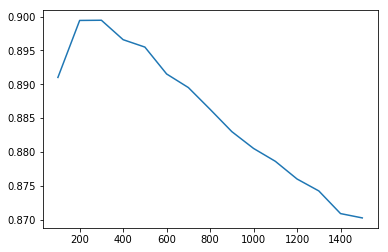

In [0]:
plt.plot(list_fitur,list_akurasi)
plt.show()

In [0]:
list_score_nb = []
for category in dataset.aspek_kategori:
#     category = 'akurasi'
    data, labels = dataset.get_sentimen(category);
    # data['classes'] = sorted(list(set(data['test_y'])))
#     corpus = [" ".join(x) for x in data]
#     vectorizer = TfidfVectorizer(max_features=300)
#     save_tfidf(vectorizer.fit(corpus), category, 'aspek', 'mnb')
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    acc, prec, rec, f1 = 0,0,0,0
    k = 0
    for train_idx, test_idx in kfold.split(data):
        corpus = [" ".join(x) for x in [data[y] for y in train_idx]]
        tf_idf_matrix = TfidfVectorizer()
#             tf_idf_matrix = load_tfidf(category,'sentimen', 'mnb')
        tf_idf_matrix.fit_transform(corpus)
        train_x = tf_idf_matrix.transform([" ".join(data[x]) for x in train_idx])
        train_y = [labels[x] for x in train_idx]
        test_x = tf_idf_matrix.transform([" ".join(data[x]) for x in test_idx])
        test_y = [labels[x] for x in test_idx]
        clf = MultinomialNB()
        clf.fit(train_x, train_y)
        pred_y = clf.predict(test_x)
        
        a, p, r, f = hitung_score(test_y,pred_y)
        k += 1
        print("k=",k,"Aspek:",category,"/","akurasi:",a)
        acc += a
        prec += p
        rec += r
        f1 += f
    print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    score = {
            "label" : category,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    list_score_nb.append(score)
df_nb = pd.DataFrame.from_dict(list_score_nb)
df_nb = df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']]
df_nb.to_csv(f'data/Catatan Eksperimen 3/sentimen_best_params_mnb_score.csv')
print("- Model MNB\n",df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")

k= 1 Aspek: akurasi / akurasi: 0.8649068322981367
k= 2 Aspek: akurasi / akurasi: 0.9145962732919255
k= 3 Aspek: akurasi / akurasi: 0.8680124223602484
k= 4 Aspek: akurasi / akurasi: 0.9020217729393468
k= 5 Aspek: akurasi / akurasi: 0.8786936236391913
K-Fold 5 rata-rata
 Akurasi:  0.8856461849057696 presisi:  0.871210364330947 recall:  0.9802610565352239 F1: 0.9223060000686744
k= 1 Aspek: kualitas / akurasi: 0.8492520138089759
k= 2 Aspek: kualitas / akurasi: 0.8515535097813579
k= 3 Aspek: kualitas / akurasi: 0.856156501726122
k= 4 Aspek: kualitas / akurasi: 0.8642117376294591
k= 5 Aspek: kualitas / akurasi: 0.8675115207373272
K-Fold 5 rata-rata
 Akurasi:  0.8577370567366485 presisi:  0.8380912181157093 recall:  0.9847238952435813 F1: 0.9054767348915295
k= 1 Aspek: pelayanan / akurasi: 0.8933823529411765
k= 2 Aspek: pelayanan / akurasi: 0.8823529411764706
k= 3 Aspek: pelayanan / akurasi: 0.8602941176470589
k= 4 Aspek: pelayanan / akurasi: 0.8860294117647058
k= 5 Aspek: pelayanan / akurasi

- Testing

In [0]:
list_score_cnn = []
list_score_mnb = []
for category in data_aspek.aspek_kategori:
    data['train_x'], data['test_x'], data['train_y'], data['test_y'] = data_sentimen.get_sentimen(category)
    data['classes'] = sorted(list(set(data['test_y'])))
    corpus = [" ".join(x) for x in data['train_x']]
    tf_idf_matrix_mnb = load_tfidf(category,'sentimen', 'mnb')
    test_x_mnb = tf_idf_matrix_mnb.transform([" ".join(x) for x in data['test_x']])
    test_y = [data['classes'].index(c) for c in data['test_y']]
    
    #CNN
    mdl_cnn = CNN_2(**params)
    acc, prec, recc, f1 = test(mdl_cnn,data, f"sentimen_{category}_best_params.pt")
    score = {
        "label" : category,
        "akurasi" : acc,
        "presisi" : prec,
        "recall" : recc,
        "f1" : f1
    }
    list_score_cnn.append(score)
    #naive bayes
    mdl_mnb = pickle.load(open(f"data/model/sentimen/naive_bayes/{category}_model_mnb.pkl", 'rb'))
    y_pred = mdl_mnb.predict(test_x_mnb)
    acc, prec, recc, f1 = hitung_score(test_y,y_pred)
    score = {
        "label" : category,
        "akurasi" : acc,
        "presisi" : prec,
        "recall" : recc,
        "f1" : f1
    }
    list_score_mnb.append(score)
    
df_cnn = pd.DataFrame.from_dict(list_score_cnn)
df_cnn = df_cnn[['label', 'akurasi', 'presisi', 'recall', 'f1']]
df_cnn.to_csv(f'data/Catatan Eksperimen/sentimen_best_params_cnn_score.csv')
df_mnb = pd.DataFrame.from_dict(list_score_mnb)
df_mnb = df_mnb[['label', 'akurasi', 'presisi', 'recall', 'f1']]
df_mnb.to_csv(f'data/Catatan Eksperimen/sentimen_best_params_mnb_score.csv')
print("- Model CNN\n",df_cnn[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")
print("- Model MNB\n",df_mnb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")

- Model CNN
         label  akurasi  presisi  recall    f1
0     akurasi     0.95     0.95    0.97  0.96
1    kualitas     0.92     0.93    0.95  0.94
2   pelayanan     0.92     0.95    0.94  0.94
3  pengemasan     0.92     0.95    0.95  0.95
4       harga     0.89     0.90    0.97  0.93
5  pengiriman     0.93     0.94    0.96  0.95 

- Model MNB
         label  akurasi  presisi  recall    f1
0     akurasi     0.89     0.87    0.98  0.92
1    kualitas     0.90     0.90    0.97  0.93
2   pelayanan     0.89     0.87    0.97  0.92
3  pengemasan     0.87     0.86    0.97  0.91
4       harga     0.82     0.81    1.00  0.90
5  pengiriman     0.88     0.85    0.99  0.92 



## Pengujian Prediksi Sentimen

In [0]:
list_score_cnn = []
for category in dataset.aspek_kategori:
    print("="*10,category,"="*10)
    teks_x, _ = dataset.get_sentimen(category)
    x,y = dataset.get_sentimen_w2v(category)
    x = np.reshape(x, (len(x),1,154,300))
    parameters['EPOCH'] = 60
    parameters['FILTERS'] = [(3,300),(4,300),(5,300)]
    parameters['FILTERS_NUM'] =  [400,400,400]
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    trains, tests = [], []
    acc, prec, rec, f1 = 0, 0, 0, 0
    idx_k = 0
    start_time = time.time()
    for train, test in kfold.split(x):
        idx_k+=1
        print("K = ",idx_k)
        
        
        model_aspek = train_cnn_2(x[train], y[train], x[test], y[test])
        output_asp = model_aspek(torch.cuda.FloatTensor(x[test]))
        save_model(model_aspek,f"data/Catatan Eksperimen 4/model/model_sentimen_{category}_k_{idx_k}")
        pred_asp = torch.max(output_asp.data, dim=1)[1].cpu().numpy().tolist()
        
        pred_csv = []
        for i,j in zip(test,pred_asp):
            pred_csv_item = {
                "teks": " ".join(teks_x[i]),
                "prediksi": j,
                "target": y[i]
            }
            pred_csv.append(pred_csv_item)
        df_pred = pd.DataFrame.from_dict(pred_csv)
        df_pred_sort = df_pred[['teks', 'prediksi', 'target']]
        df_pred_sort.to_csv(f'data/Catatan Eksperimen 4/data_hasil/prediksi_sentimen_{category}_k_{idx_k}.csv')
        
        a, p, r, f = hitung_score(y[test],pred_asp)
        acc += a
        prec += p
        rec += r
        f1 += f

    time_dif = get_time_dif(start_time)
    print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    score = {
            "label" : category,
            "waktu" : time_dif.total_seconds()/60,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    list_score_cnn.append(score)
df_cnn = pd.DataFrame.from_dict(list_score_cnn)
df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
df_sort.to_csv(f'data/Catatan Eksperimen 4/sentimen_prediksi_score.csv')
print(f"- Model CNN epoch \n",df_sort.round(2),"\n")

========== akurasi ==========
K =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  58.57%, Train_acc 84.89%, Test_loss: 59.25%, Test_acc 83.39%, Time: 0:00:02
Epoch   2, Train_loss:  52.11%, Train_acc 87.49%, Test_loss: 53.77%, Test_acc 84.63%, Time: 0:00:04
Epoch   3, Train_loss:  46.90%, Train_acc 89.04%, Test_loss: 48.55%, Test_acc 86.49%, Time: 0:00:06
Epoch   4, Train_loss:  42.99%, Train_acc 90.13%, Test_loss: 45.13%, Test_acc 88.51%, Time: 0:00:08
Epoch   5, Train_loss:  39.51%, Train_acc 90.48%, Test_loss: 41.30%, Test_acc 90.22%, Time: 0:00:11
Epoch   6, Train_loss:  36.80%, Train_acc 90.02%, Test_loss: 39.03%, Test_acc 89.13%, Time: 0:00:13
Epoch   7, Train_loss:  34.41%, Train_acc 90.52%, Test_loss: 36.84%, Test_acc 89.75%, Time: 0:00:15
Epoch   8, Train_loss:  31.99%, Train_acc 90.75%, Test_loss: 34.58%, Test_acc 89.91%, Time: 0:00:17
Epoch   9, Train_loss:  30.49%, Train_acc 91.03%, Test_loss: 32.66%, Test_acc 90.84%, Time: 0:00:19
Epoch  10, Train_loss:  28.80%, Train_acc 91.26%, Test_loss: 31.26%, Test_acc 90.99%, Time: 0:00:21


# Klasifikasi Aspek dan Sentimen

## cnn

In [0]:
parameters['EPOCH'] = 60
list_score_cnn = []
for cat in dataset.aspek_kategori:
    print("="*10,cat,"="*10)
    x_aspek, y_aspek = dataset.get_aspek_w2v(cat)
    x_sentimen, y_sentimen = dataset.get_sentimen_w2v(cat)
    x_aspek = np.reshape(x_aspek, (len(x_aspek),1,154,300))
    x_sentimen = np.reshape(x_sentimen, (len(x_sentimen),1,154,300))
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    trains, tests = [], []
    acc, prec, rec, f1 = 0, 0, 0, 0
    idx_k = 0
    start_time = time.time()
    for (train_asp, test_asp),(train_sent, test_sent) in zip(kfold.split(x_aspek),kfold.split(x_sentimen)):
        idx_k+=1
        print("K = ",idx_k)
        print("="*10,cat,'-train aspek',"="*10)
        parameters['FILTERS'] = [(2,300), (3,300), (4,300)]
        parameters['FILTERS_NUM'] = [100,100,100]
        model_aspek = train_cnn_2(x_aspek[train_asp], y_aspek[train_asp], x_aspek[test_asp], y_aspek[test_asp])
        output_asp = model_aspek(torch.cuda.FloatTensor(x_sentimen[test_sent]))
        pred_asp = torch.max(output_asp.data, dim=1)[1].cpu().numpy().tolist()

        print("="*10,cat,'-train sentimen',"="*10)
        parameters['FILTERS'] = [(3,300), (4,300), (5,300)]
        parameters['FILTERS_NUM'] = [400,400,400]
        model_sentimen = train_cnn_2(x_sentimen[train_sent], y_sentimen[train_sent], x_sentimen[test_sent], y_sentimen[test_sent])
        output_sent = model_sentimen(torch.cuda.FloatTensor(x_sentimen[test_sent]))
        pred_sent = torch.max(output_sent.data, dim=1)[1].cpu().numpy().tolist()

        for i, data in enumerate(pred_asp):
            if pred_asp[i] == 0:
                pred_sent[i] = -1
        print(pred_asp)
        print(pred_sent)
        a, p, r, f = hitung_score_multiclass(y_sentimen[test_sent],pred_sent)
        acc += a
        prec += p
        rec += r
        f1 += f
        time_dif = get_time_dif(start_time)
        score = {
            "label" : cat,
            "waktu" : time_dif.total_seconds()/60,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    print("K-Fold 5", "Waktu-menit: ",time_dif.total_seconds()/60,"Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    list_score_cnn.append(score)
df_cnn = pd.DataFrame.from_dict(list_score_cnn)
df_sort = df_cnn[['label', 'waktu', 'akurasi', 'presisi', 'recall', 'f1']]
df_sort.to_csv(f'data/Catatan Eksperimen 3/aspek_sentimen_cnn_score.csv')
print(f"- aspek_sentimen score\n",df_sort.round(2),"\n")

========== akurasi ==========
K =  1
========== akurasi -train aspek ==========


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


Epoch   1, Train_loss:  73.62%, Train_acc 43.00%, Test_loss: 73.55%, Test_acc 43.60%, Time: 0:00:04
Epoch   2, Train_loss:  72.56%, Train_acc 42.93%, Test_loss: 72.33%, Test_acc 43.60%, Time: 0:00:08
Epoch   3, Train_loss:  69.91%, Train_acc 43.37%, Test_loss: 70.05%, Test_acc 44.07%, Time: 0:00:12
Epoch   4, Train_loss:  66.41%, Train_acc 45.15%, Test_loss: 66.27%, Test_acc 46.00%, Time: 0:00:16
Epoch   5, Train_loss:  62.54%, Train_acc 50.23%, Test_loss: 62.76%, Test_acc 49.20%, Time: 0:00:20
Epoch   6, Train_loss:  58.82%, Train_acc 56.92%, Test_loss: 58.93%, Test_acc 56.67%, Time: 0:00:24
Epoch   7, Train_loss:  55.18%, Train_acc 65.08%, Test_loss: 55.20%, Test_acc 64.93%, Time: 0:00:28
Epoch   8, Train_loss:  51.79%, Train_acc 73.85%, Test_loss: 51.89%, Test_acc 73.20%, Time: 0:00:32
Epoch   9, Train_loss:  48.77%, Train_acc 79.53%, Test_loss: 48.99%, Test_acc 78.93%, Time: 0:00:36
Epoch  10, Train_loss:  46.21%, Train_acc 83.33%, Test_loss: 46.56%, Test_acc 82.87%, Time: 0:00:40


## mnb

In [0]:
list_score_nb = []
for category in dataset.aspek_kategori:
#     category = 'akurasi'
    x_aspek, y_aspek = dataset.get_aspek(category)
    x_sentimen, y_sentimen = dataset.get_sentimen(category)
    # data['classes'] = sorted(list(set(data['test_y'])))
    corpus_asp = [" ".join(x) for x in x_aspek]
    corpus_sent = [" ".join(x) for x in x_aspek]
    vectorizer_asp = TfidfVectorizer(max_features=700)
    vectorizer_sent = TfidfVectorizer(max_features=700)
    save_tfidf(vectorizer_asp.fit(corpus_asp), category, 'aspek', 'mnb')
    save_tfidf(vectorizer_sent.fit(corpus_sent), category, 'sentimen', 'mnb')
    kfold = KFold(n_splits=5, shuffle=True, random_state=44)
    acc, prec, rec, f1 = 0,0,0,0
    k = 0
    # for train_idx, test_idx in kfold.split(data):
    for (train_asp, test_asp),(train_sent, test_sent) in zip(kfold.split(x_aspek),kfold.split(x_sentimen)):
        tf_idf_matrix_asp = load_tfidf(category,'aspek', 'mnb')
        train_asp_x = tf_idf_matrix_asp.transform([" ".join(x_aspek[x]) for x in train_asp])
        train_asp_y = [y_aspek[x] for x in train_asp]
        test_asp_x = tf_idf_matrix_asp.transform([" ".join(x_aspek[x]) for x in test_asp])
        test_asp_y = [y_aspek[x] for x in test_asp]

        tf_idf_matrix_sent = load_tfidf(category,'sentimen', 'mnb')
        train_sent_x = tf_idf_matrix_sent.transform([" ".join(x_sentimen[x]) for x in train_sent])
        train_sent_y = [y_sentimen[x] for x in train_sent]
        test_sent_x = tf_idf_matrix_sent.transform([" ".join(x_sentimen[x]) for x in test_sent])
        test_sent_y = [y_sentimen[x] for x in test_sent]

        model_aspek = MultinomialNB()
        model_aspek.fit(train_asp_x, train_asp_y)
        pred_asp = model_aspek.predict(test_sent_x)

        model_sentimen = MultinomialNB()
        model_sentimen.fit(train_sent_x, train_sent_y)
        pred_sent = model_sentimen.predict(test_sent_x)
        
        for i, data in enumerate(pred_asp):
            if pred_asp[i] == 0:
                pred_sent[i] = -1
        # print(pred_asp)
        # print(pred_sent)
        a, p, r, f = hitung_score_multiclass(test_sent_y,pred_sent)
        k += 1
        print("k=",k,"Aspek:",category,"/","akurasi:",a)
        acc += a
        prec += p
        rec += r
        f1 += f
    print("K-Fold 5 rata-rata\n", "Akurasi: ",acc/5, "presisi: ", prec/5, "recall: ", rec/5, "F1:", f1/5)
    score = {
            "label" : category,
            "akurasi" : acc/5,
            "presisi" : prec/5,
            "recall" : rec/5,
            "f1" : f1/5
        }
    list_score_nb.append(score)
df_nb = pd.DataFrame.from_dict(list_score_nb)
df_nb = df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']]
df_nb.to_csv(f'data/Catatan Eksperimen 3/aspek_sentimen_mnb_score.csv')
print("- Model MNB\n",df_nb[['label', 'akurasi', 'presisi', 'recall', 'f1']].round(2),"\n")

[[  0   0   0]
 [ 59 113  37]
 [ 70  10 355]]
k= 1 Aspek: akurasi / akurasi: 0.7267080745341615
[[  0   0   0]
 [ 77  99  18]
 [ 76  14 360]]
k= 2 Aspek: akurasi / akurasi: 0.7127329192546584
[[  0   0   0]
 [ 59 102  42]
 [ 66   9 366]]
k= 3 Aspek: akurasi / akurasi: 0.7267080745341615
[[  0   0   0]
 [ 62 112  22]
 [ 59  14 374]]
k= 4 Aspek: akurasi / akurasi: 0.7558320373250389
[[  0   0   0]
 [ 61 100  29]
 [ 78  11 364]]
k= 5 Aspek: akurasi / akurasi: 0.7216174183514774
K-Fold 5 rata-rata
 Akurasi:  0.7287197047998996 presisi:  0.9251410233304517 recall:  0.8172489947346891 F1: 0.8676216298256524
[[  0   0   0]
 [ 11 199  70]
 [ 94  20 475]]
k= 1 Aspek: kualitas / akurasi: 0.7756041426927502
[[  0   0   0]
 [ 11 188  67]
 [107  27 469]]
k= 2 Aspek: kualitas / akurasi: 0.7560414269275029
[[  0   0   0]
 [  7 202  57]
 [116  31 456]]
k= 3 Aspek: kualitas / akurasi: 0.757192174913694
[[  0   0   0]
 [  9 188  62]
 [106  26 478]]
k= 4 Aspek: kualitas / akurasi: 0.766398158803222
[[  0

## Prediksi menggunakan CNN

In [0]:
def sent_to_w2v(kalimat):
    preprocess = Preprocess(kalimat)
    kalimat = preprocess.preprocessing()
    kalimat = [x.split(" ") for x in kalimat]
    coba = dataset.dataframe_to_vector(kalimat)
    coba = np.asarray(coba)
    
    return torch.FloatTensor(coba)

def predict(data):
    sents_idx = sent_to_w2v(data['teks'])
    aspects_y = ['akurasi_y', 'kualitas_y', 'pelayanan_y', 'pengemasan_y', 'harga_y', 'pengiriman_y']
    aspects = ['akurasi', 'kualitas', 'pelayanan', 'pengemasan', 'harga', 'pengiriman']
    set_label_aspek = [0,1]
    set_label_sentimen = ["negatif", "positif"]
    aspek_pred = []
    sentimen_pred = []
    parameters["FILTERS_NUM"] = [100,100,100]
    parameters['FILTERS'] = [(2,300),(3,300),(4,300)]
    model_asp = CNN_softmax(**parameters)
    parameters["FILTERS_NUM"] = [400,400,400]
    parameters['FILTERS'] = [(3,300),(4,300),(5,300)]
    model_senti = CNN_softmax(**parameters)
    for i,sent in enumerate(sents_idx):
        sent_reshape = torch.reshape(sent,(1,1,154,300))
        label_aspek = {}
        for y, aspect in zip(aspects_y, aspects):
            path_asp = f"data/Catatan Eksperimen 4/model/model_aspek_{aspect}_k_3"
#             print(path_asp)
            load_model(model_asp,path_asp)
            model_asp.eval()
            output = model_asp(sent_reshape)
            pred = torch.max(output,1)[1]
            label_aspek['teks'] = data['teks'][i]
            label_aspek[y] = set_label_aspek[pred.data[0]]
            label_aspek[aspect] = 0 if data[aspect][i] == '-' else 1
        aspek_pred.append(label_aspek)
        label_sentimen = {}
        for y, cat in zip(aspects_y, aspects):
            if label_aspek[y] == 1:
                path_senti = f"data/Catatan Eksperimen 4/model/model_sentimen_{cat}_k_3"
#                 print(path_senti)
                load_model(model_senti,path_senti)
                model_senti.eval()
                output = model_senti(sent_reshape)
                pred = torch.max(output,1)[1]
                label_sentimen['teks'] = data['teks'][i]
                label_sentimen[y] = set_label_sentimen[pred.data[0]]
                label_sentimen[cat] = data[cat][i]
#                 print(i,':',set_label_sentimen[pred.data[0]])
            else:
                label_sentimen[y] = "-"
                label_sentimen[cat] = data[cat][i]
#                 print(i,' : -')
        sentimen_pred.append(label_sentimen)
        print(label_sentimen['teks'])
        for y, cat in zip(aspects_y, aspects):
            print(cat,":",label_sentimen[y], label_sentimen[cat])
        
        print('\n')
#     print(sentimen_pred)
    df_pred = pd.DataFrame.from_dict(sentimen_pred)
    df_pred_sort = df_pred[['teks','akurasi_y', 'akurasi', 'kualitas_y', 'kualitas', 'pelayanan_y','pelayanan', 'pengemasan_y', 'pengemasan', 'harga_y', 'harga', 'pengiriman_y', 'pengiriman']]
    df_pred_sort.to_csv(f'data/Catatan Eksperimen 4/prediksi_sentimen.csv')